In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
class Generator(nn.Module):
    def __init__(self, channels,img_size):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.channels = channels
        self.gen = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, self.channels*self.img_size*self.img_size),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.gen(x)
        return x.view(x.size(0), self.channels, self.img_size, self.img_size)

class Discriminator(nn.Module):
    def __init__(self, channels,img_size):
        super(Discriminator, self).__init__()
        self.img_size = img_size
        self.channels = channels
        self.dis = nn.Sequential(
            nn.Linear(self.channels*self.img_size*self.img_size, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.dis(x)

In [8]:
from torchviz import make_dot

model = Generator(1,28)
noise = torch.randn(1, 100)
output = model(noise)
make_dot(output, params=dict(model.named_parameters())).render("generator_architecture", format="png")

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [3]:
def get_dataset(dataset_name):
    if dataset_name == 'MNIST':
        img_channels = 1
        img_size = 28
        transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        dataset = datasets.MNIST(root='mnist_data', train=True, transform=transform, download=True)
    elif dataset_name == 'CIFAR10':
        img_channels = 3
        img_size = 32
        transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        dataset = datasets.CIFAR10(root='cifar10_data', train=True, transform=transform, download=True)
    elif dataset_name == 'CIFAR100':
        img_channels = 3
        img_size = 32
        transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        dataset = datasets.CIFAR100(root='cifar100_data', train=True, transform=transform, download=True)

    return dataset, img_channels, img_size

In [4]:
def train(dataset_name, g_lr=2e-4, d_lr=2e-4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_dataset, img_channels, img_size = get_dataset(dataset_name)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    generator = Generator(img_channels, img_size).to(device)
    discriminator = Discriminator(img_channels, img_size).to(device)

    criterion = nn.BCELoss()
    optimizer_g = optim.Adam(generator.parameters(), lr=g_lr, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=d_lr, betas=(0.5, 0.999))
    num_epochs = 60
    fixed_noise = torch.randn(64, 100).to(device)

    g_losses = []
    d_losses = []

    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(train_loader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)

#             # Smooth labels
#             real_labels = torch.full((batch_size,), 0.9, dtype=torch.float, device=device)
#             fake_labels = torch.full((batch_size,), 0.1, dtype=torch.float, device=device)
            real_labels = torch.ones((batch_size,),device=device)
            fake_labels = torch.zeros((batch_size,),device=device)

            # Train Discriminator
            optimizer_d.zero_grad()
            outputs = discriminator(real_images).view(-1)
            d_loss_real = criterion(outputs, real_labels)
            d_loss_real.backward()

            z = torch.randn(batch_size, 100).to(device)
            fake_images = generator(z)
            outputs = discriminator(fake_images.detach()).view(-1)
            d_loss_fake = criterion(outputs, fake_labels)
            d_loss_fake.backward()

            optimizer_d.step()

            d_loss = d_loss_real + d_loss_fake
            d_losses.append(d_loss.item())

            # Train Generator
            optimizer_g.zero_grad()
            outputs = discriminator(fake_images).view(-1)
            g_loss = criterion(outputs, real_labels)
            g_loss.backward()

            optimizer_g.step()

            g_losses.append(g_loss.item())

            if i % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}')

        if (epoch + 1) % 10 == 0:
            with torch.no_grad():
                fake_images = generator(fixed_noise).cpu()
                grid = utils.make_grid(fake_images, padding=2, normalize=True)
                plt.figure(figsize=(8, 8))
                plt.axis("off")
                plt.title("Generated Images")
                if grid.shape[0] == 1:
                    plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap="gray")  # Handle grayscale images
                else:
                    plt.imshow(np.transpose(grid, (1, 2, 0)))  # Handle RGB images
                plt.show()

    # Plot the loss curves
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(g_losses, label="G")
    plt.plot(d_losses, label="D")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

Epoch [1/60], Step [1/938], d_loss: 1.3787678480148315, g_loss: 0.6718083024024963
Epoch [1/60], Step [101/938], d_loss: 1.2442448139190674, g_loss: 0.9169995784759521
Epoch [1/60], Step [201/938], d_loss: 0.3872682452201843, g_loss: 2.0146241188049316
Epoch [1/60], Step [301/938], d_loss: 0.6442123651504517, g_loss: 3.381030559539795
Epoch [1/60], Step [401/938], d_loss: 0.9726519584655762, g_loss: 4.04775857925415
Epoch [1/60], Step [501/938], d_loss: 0.491913765668869, g_loss: 2.5998783111572266
Epoch [1/60], Step [601/938], d_loss: 0.8266610503196716, g_loss: 6.64105224609375
Epoch [1/60], Step [701/938], d_loss: 0.5693539381027222, g_loss: 2.936431884765625
Epoch [1/60], Step [801/938], d_loss: 0.48666417598724365, g_loss: 2.2094216346740723
Epoch [1/60], Step [901/938], d_loss: 0.30005475878715515, g_loss: 3.035083770751953
Epoch [2/60], Step [1/938], d_loss: 0.5265892744064331, g_loss: 2.8601503372192383
Epoch [2/60], Step [101/938], d_loss: 0.3918907046318054, g_loss: 2.7072939

Epoch [10/60], Step [701/938], d_loss: 0.7150050401687622, g_loss: 2.3866543769836426
Epoch [10/60], Step [801/938], d_loss: 0.9111698865890503, g_loss: 1.4314336776733398
Epoch [10/60], Step [901/938], d_loss: 0.8158242106437683, g_loss: 1.675685167312622


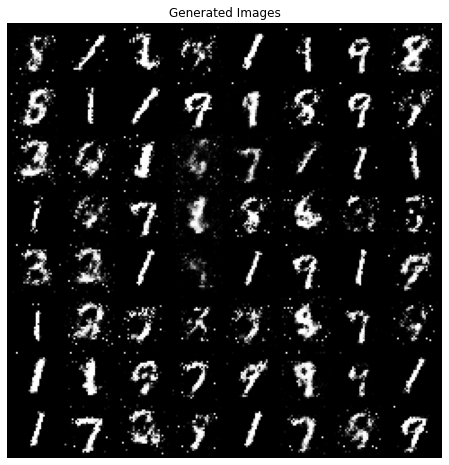

Epoch [11/60], Step [1/938], d_loss: 0.700411856174469, g_loss: 1.5608713626861572
Epoch [11/60], Step [101/938], d_loss: 0.9082368612289429, g_loss: 3.1122565269470215
Epoch [11/60], Step [201/938], d_loss: 0.8480693101882935, g_loss: 1.237392544746399
Epoch [11/60], Step [301/938], d_loss: 0.9759215712547302, g_loss: 1.7953840494155884
Epoch [11/60], Step [401/938], d_loss: 0.7109012007713318, g_loss: 2.943636894226074
Epoch [11/60], Step [501/938], d_loss: 0.8733251094818115, g_loss: 1.4617359638214111
Epoch [11/60], Step [601/938], d_loss: 0.7369449734687805, g_loss: 1.4799244403839111
Epoch [11/60], Step [701/938], d_loss: 0.6956378221511841, g_loss: 2.001220703125
Epoch [11/60], Step [801/938], d_loss: 0.8708168268203735, g_loss: 1.6824201345443726
Epoch [11/60], Step [901/938], d_loss: 0.7901328802108765, g_loss: 1.6684741973876953
Epoch [12/60], Step [1/938], d_loss: 0.8629990816116333, g_loss: 1.8564757108688354
Epoch [12/60], Step [101/938], d_loss: 0.8493341207504272, g_loss

Epoch [20/60], Step [701/938], d_loss: 0.8805187940597534, g_loss: 1.4645103216171265
Epoch [20/60], Step [801/938], d_loss: 0.7751584649085999, g_loss: 1.6811344623565674
Epoch [20/60], Step [901/938], d_loss: 0.9621257781982422, g_loss: 1.7925561666488647


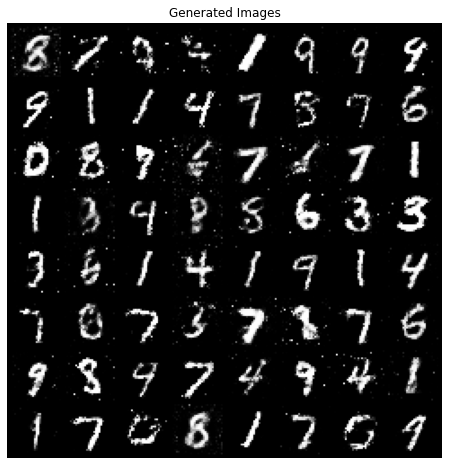

Epoch [21/60], Step [1/938], d_loss: 0.9368678331375122, g_loss: 1.2483329772949219
Epoch [21/60], Step [101/938], d_loss: 0.9147157669067383, g_loss: 1.991587519645691
Epoch [21/60], Step [201/938], d_loss: 0.7917633056640625, g_loss: 1.575920581817627
Epoch [21/60], Step [301/938], d_loss: 0.8911885023117065, g_loss: 1.4810419082641602
Epoch [21/60], Step [401/938], d_loss: 0.7954338788986206, g_loss: 2.0420308113098145
Epoch [21/60], Step [501/938], d_loss: 0.8608079552650452, g_loss: 1.5853384733200073
Epoch [21/60], Step [601/938], d_loss: 1.001916527748108, g_loss: 1.6225428581237793
Epoch [21/60], Step [701/938], d_loss: 0.7677964568138123, g_loss: 1.5141792297363281
Epoch [21/60], Step [801/938], d_loss: 0.9551470279693604, g_loss: 1.2455601692199707
Epoch [21/60], Step [901/938], d_loss: 0.8493659496307373, g_loss: 1.594602346420288
Epoch [22/60], Step [1/938], d_loss: 0.8294484615325928, g_loss: 1.5186463594436646
Epoch [22/60], Step [101/938], d_loss: 0.8857353925704956, g_l

Epoch [30/60], Step [601/938], d_loss: 1.0073875188827515, g_loss: 1.4540541172027588
Epoch [30/60], Step [701/938], d_loss: 0.9525135159492493, g_loss: 1.808412790298462
Epoch [30/60], Step [801/938], d_loss: 0.9072244167327881, g_loss: 1.2523577213287354
Epoch [30/60], Step [901/938], d_loss: 1.0476861000061035, g_loss: 0.880487322807312


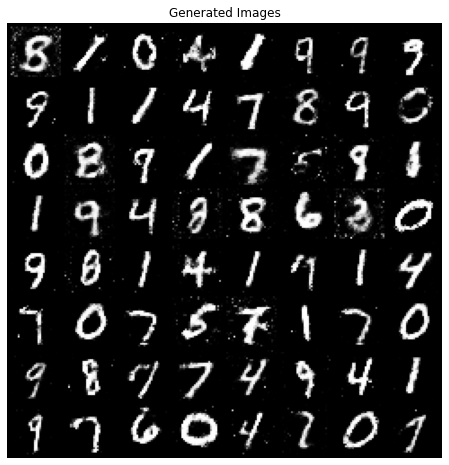

Epoch [31/60], Step [1/938], d_loss: 0.9403561353683472, g_loss: 1.3036844730377197
Epoch [31/60], Step [101/938], d_loss: 0.8977197408676147, g_loss: 1.2727580070495605
Epoch [31/60], Step [201/938], d_loss: 0.9329711198806763, g_loss: 1.9451074600219727
Epoch [31/60], Step [301/938], d_loss: 1.0786020755767822, g_loss: 1.41288423538208
Epoch [31/60], Step [401/938], d_loss: 1.073938250541687, g_loss: 1.0184515714645386
Epoch [31/60], Step [501/938], d_loss: 0.9296709895133972, g_loss: 1.1829633712768555
Epoch [31/60], Step [601/938], d_loss: 0.8492605090141296, g_loss: 1.7876051664352417
Epoch [31/60], Step [701/938], d_loss: 0.7822703123092651, g_loss: 1.501187801361084
Epoch [31/60], Step [801/938], d_loss: 0.8867346048355103, g_loss: 1.5790865421295166
Epoch [31/60], Step [901/938], d_loss: 0.9384596347808838, g_loss: 1.549274206161499
Epoch [32/60], Step [1/938], d_loss: 0.9290765523910522, g_loss: 1.1369224786758423
Epoch [32/60], Step [101/938], d_loss: 0.8716367483139038, g_lo

Epoch [40/60], Step [601/938], d_loss: 0.9897863864898682, g_loss: 1.5000817775726318
Epoch [40/60], Step [701/938], d_loss: 1.0104804039001465, g_loss: 1.281329870223999
Epoch [40/60], Step [801/938], d_loss: 1.0357978343963623, g_loss: 1.3226397037506104
Epoch [40/60], Step [901/938], d_loss: 0.9542665481567383, g_loss: 1.3967406749725342


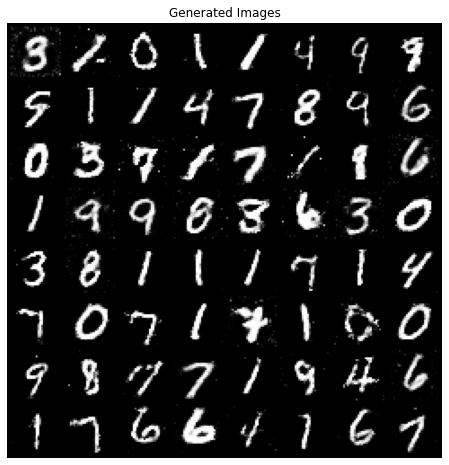

Epoch [41/60], Step [1/938], d_loss: 1.0238661766052246, g_loss: 1.853514313697815
Epoch [41/60], Step [101/938], d_loss: 0.8839998245239258, g_loss: 1.5363903045654297
Epoch [41/60], Step [201/938], d_loss: 1.0085668563842773, g_loss: 1.2981288433074951
Epoch [41/60], Step [301/938], d_loss: 1.0326247215270996, g_loss: 2.009819507598877
Epoch [41/60], Step [401/938], d_loss: 0.8827677965164185, g_loss: 1.811096429824829
Epoch [41/60], Step [501/938], d_loss: 0.9807168245315552, g_loss: 1.0655806064605713
Epoch [41/60], Step [601/938], d_loss: 0.8130614757537842, g_loss: 1.738600492477417
Epoch [41/60], Step [701/938], d_loss: 0.9119715690612793, g_loss: 1.455784797668457
Epoch [41/60], Step [801/938], d_loss: 0.9196630716323853, g_loss: 1.5939714908599854
Epoch [41/60], Step [901/938], d_loss: 0.8711533546447754, g_loss: 1.538322925567627
Epoch [42/60], Step [1/938], d_loss: 0.9413925409317017, g_loss: 1.3040474653244019
Epoch [42/60], Step [101/938], d_loss: 0.9942409992218018, g_los

Epoch [50/60], Step [701/938], d_loss: 1.098728060722351, g_loss: 1.1350609064102173
Epoch [50/60], Step [801/938], d_loss: 0.8460919260978699, g_loss: 1.3712552785873413
Epoch [50/60], Step [901/938], d_loss: 0.9149283170700073, g_loss: 1.8892865180969238


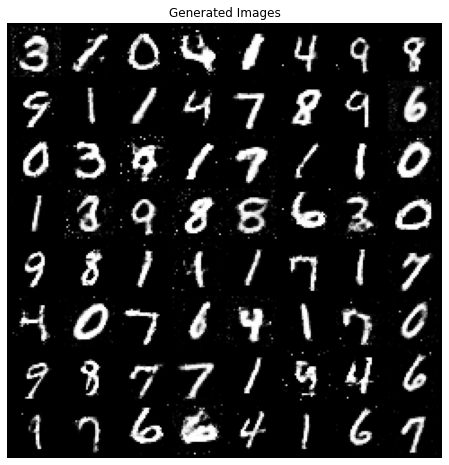

Epoch [51/60], Step [1/938], d_loss: 0.9909768104553223, g_loss: 1.3206162452697754
Epoch [51/60], Step [101/938], d_loss: 0.9929976463317871, g_loss: 1.8246288299560547
Epoch [51/60], Step [201/938], d_loss: 0.9099950790405273, g_loss: 1.794464349746704
Epoch [51/60], Step [301/938], d_loss: 0.9280481934547424, g_loss: 1.4459035396575928
Epoch [51/60], Step [401/938], d_loss: 1.0290071964263916, g_loss: 1.369448184967041
Epoch [51/60], Step [501/938], d_loss: 0.887315571308136, g_loss: 1.7376635074615479
Epoch [51/60], Step [601/938], d_loss: 0.9271523952484131, g_loss: 1.682503342628479
Epoch [51/60], Step [701/938], d_loss: 0.8869903683662415, g_loss: 1.6223134994506836
Epoch [51/60], Step [801/938], d_loss: 0.994285523891449, g_loss: 1.5526844263076782
Epoch [51/60], Step [901/938], d_loss: 1.046165943145752, g_loss: 1.3807015419006348
Epoch [52/60], Step [1/938], d_loss: 0.8601921796798706, g_loss: 1.339078664779663
Epoch [52/60], Step [101/938], d_loss: 0.8852160573005676, g_loss

Epoch [60/60], Step [701/938], d_loss: 0.9615613222122192, g_loss: 1.44624662399292
Epoch [60/60], Step [801/938], d_loss: 0.9301654100418091, g_loss: 1.5786248445510864
Epoch [60/60], Step [901/938], d_loss: 0.8460739850997925, g_loss: 1.596847653388977


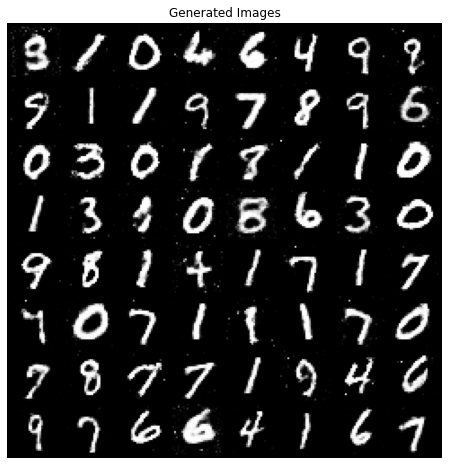

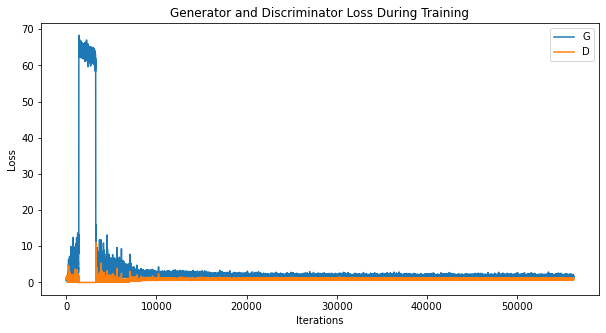

In [7]:
train('MNIST')

Files already downloaded and verified
Epoch [1/60], Step [1/782], d_loss: 1.3884758949279785, g_loss: 0.7103122472763062
Epoch [1/60], Step [101/782], d_loss: 0.926623523235321, g_loss: 0.41728776693344116
Epoch [1/60], Step [201/782], d_loss: 0.4463905990123749, g_loss: 1.042558193206787
Epoch [1/60], Step [301/782], d_loss: 0.06879951059818268, g_loss: 3.1138253211975098
Epoch [1/60], Step [401/782], d_loss: 0.34372296929359436, g_loss: 3.2111246585845947
Epoch [1/60], Step [501/782], d_loss: 0.22614960372447968, g_loss: 2.9759788513183594
Epoch [1/60], Step [601/782], d_loss: 0.3789595365524292, g_loss: 2.4466052055358887
Epoch [1/60], Step [701/782], d_loss: 0.5138291716575623, g_loss: 2.388925313949585
Epoch [2/60], Step [1/782], d_loss: 0.4414031505584717, g_loss: 2.173577070236206
Epoch [2/60], Step [101/782], d_loss: 0.6415445804595947, g_loss: 4.862109184265137
Epoch [2/60], Step [201/782], d_loss: 0.6693419218063354, g_loss: 2.8301734924316406
Epoch [2/60], Step [301/782], d_

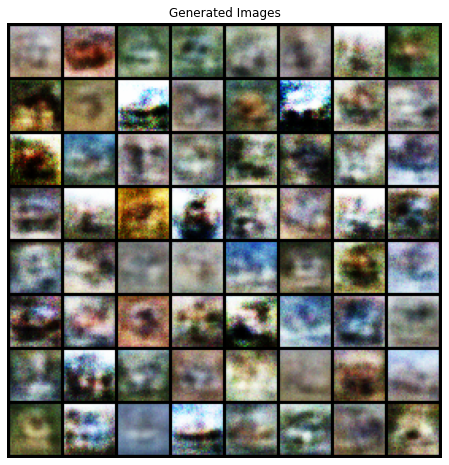

Epoch [11/60], Step [1/782], d_loss: 1.4107611179351807, g_loss: 1.5882039070129395
Epoch [11/60], Step [101/782], d_loss: 1.162174940109253, g_loss: 1.3049224615097046
Epoch [11/60], Step [201/782], d_loss: 1.4045586585998535, g_loss: 0.8563485741615295
Epoch [11/60], Step [301/782], d_loss: 1.251214623451233, g_loss: 0.7111470699310303
Epoch [11/60], Step [401/782], d_loss: 1.2629395723342896, g_loss: 0.8914583921432495
Epoch [11/60], Step [501/782], d_loss: 1.3160662651062012, g_loss: 1.0326712131500244
Epoch [11/60], Step [601/782], d_loss: 1.2869842052459717, g_loss: 1.0413841009140015
Epoch [11/60], Step [701/782], d_loss: 1.177266001701355, g_loss: 1.1918022632598877
Epoch [12/60], Step [1/782], d_loss: 1.3802719116210938, g_loss: 1.4758789539337158
Epoch [12/60], Step [101/782], d_loss: 1.3587018251419067, g_loss: 0.790482223033905
Epoch [12/60], Step [201/782], d_loss: 1.3219060897827148, g_loss: 1.0465306043624878
Epoch [12/60], Step [301/782], d_loss: 1.4996484518051147, g_l

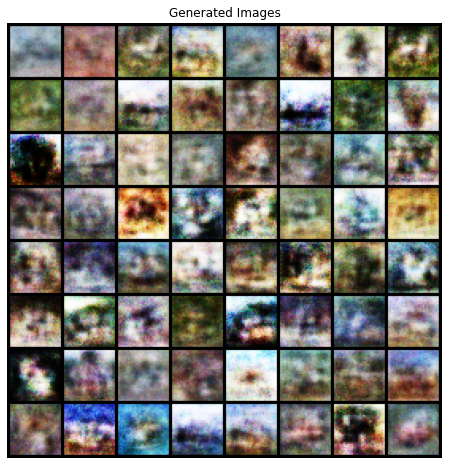

Epoch [21/60], Step [1/782], d_loss: 1.6144757270812988, g_loss: 1.424195647239685
Epoch [21/60], Step [101/782], d_loss: 1.289931058883667, g_loss: 0.8757339715957642
Epoch [21/60], Step [201/782], d_loss: 1.2573761940002441, g_loss: 0.9218763113021851
Epoch [21/60], Step [301/782], d_loss: 1.2304062843322754, g_loss: 1.0248310565948486
Epoch [21/60], Step [401/782], d_loss: 1.2539550065994263, g_loss: 0.9925076961517334
Epoch [21/60], Step [501/782], d_loss: 1.361266851425171, g_loss: 1.0748043060302734
Epoch [21/60], Step [601/782], d_loss: 1.2792408466339111, g_loss: 1.0339690446853638
Epoch [21/60], Step [701/782], d_loss: 1.3759649991989136, g_loss: 0.8194925785064697
Epoch [22/60], Step [1/782], d_loss: 1.3664871454238892, g_loss: 1.1743037700653076
Epoch [22/60], Step [101/782], d_loss: 1.4456281661987305, g_loss: 0.8142591714859009
Epoch [22/60], Step [201/782], d_loss: 1.30829918384552, g_loss: 1.0524959564208984
Epoch [22/60], Step [301/782], d_loss: 1.4640765190124512, g_lo

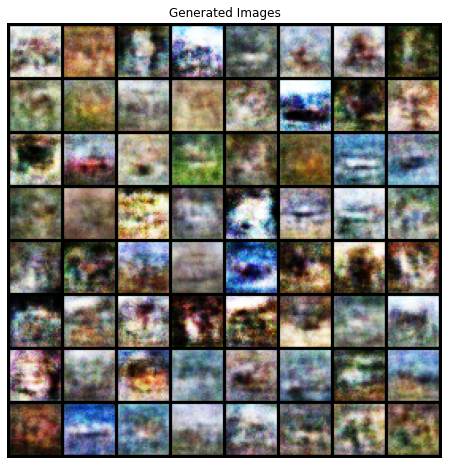

Epoch [31/60], Step [1/782], d_loss: 1.2221968173980713, g_loss: 1.1449697017669678
Epoch [31/60], Step [101/782], d_loss: 1.3171157836914062, g_loss: 1.1340839862823486
Epoch [31/60], Step [201/782], d_loss: 1.3061857223510742, g_loss: 1.400878667831421
Epoch [31/60], Step [301/782], d_loss: 1.2875027656555176, g_loss: 1.1186976432800293
Epoch [31/60], Step [401/782], d_loss: 1.3543801307678223, g_loss: 0.9957076907157898
Epoch [31/60], Step [501/782], d_loss: 1.294833779335022, g_loss: 1.0208401679992676
Epoch [31/60], Step [601/782], d_loss: 1.4797728061676025, g_loss: 0.9466743469238281
Epoch [31/60], Step [701/782], d_loss: 1.3517498970031738, g_loss: 1.1615393161773682
Epoch [32/60], Step [1/782], d_loss: 1.3259432315826416, g_loss: 1.2078770399093628
Epoch [32/60], Step [101/782], d_loss: 1.281618356704712, g_loss: 0.8405823111534119
Epoch [32/60], Step [201/782], d_loss: 1.463660478591919, g_loss: 0.8303550481796265
Epoch [32/60], Step [301/782], d_loss: 1.2779136896133423, g_l

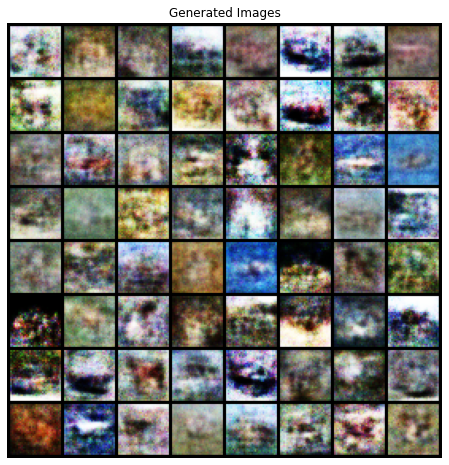

Epoch [41/60], Step [1/782], d_loss: 1.2524938583374023, g_loss: 1.2368468046188354
Epoch [41/60], Step [101/782], d_loss: 1.3242173194885254, g_loss: 0.7323740720748901
Epoch [41/60], Step [201/782], d_loss: 1.3186177015304565, g_loss: 0.9271835684776306
Epoch [41/60], Step [301/782], d_loss: 1.3569453954696655, g_loss: 1.070762038230896
Epoch [41/60], Step [401/782], d_loss: 1.2615108489990234, g_loss: 1.0482584238052368
Epoch [41/60], Step [501/782], d_loss: 1.2526414394378662, g_loss: 1.2365968227386475
Epoch [41/60], Step [601/782], d_loss: 1.3782405853271484, g_loss: 0.7600319385528564
Epoch [41/60], Step [701/782], d_loss: 1.3841365575790405, g_loss: 0.8855792284011841
Epoch [42/60], Step [1/782], d_loss: 1.2866754531860352, g_loss: 0.9627391695976257
Epoch [42/60], Step [101/782], d_loss: 1.3444546461105347, g_loss: 0.8961375951766968
Epoch [42/60], Step [201/782], d_loss: 1.3613595962524414, g_loss: 1.0014113187789917
Epoch [42/60], Step [301/782], d_loss: 1.4072010517120361, 

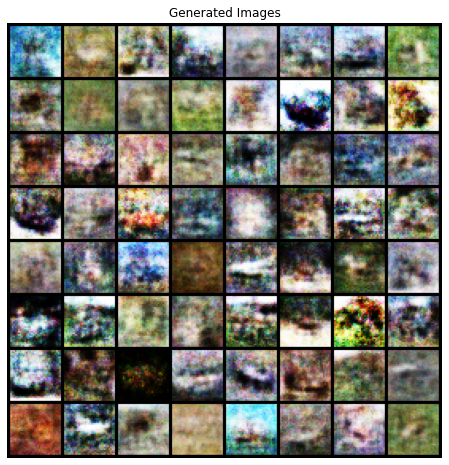

Epoch [51/60], Step [1/782], d_loss: 1.2878727912902832, g_loss: 0.8410148620605469
Epoch [51/60], Step [101/782], d_loss: 1.4655141830444336, g_loss: 0.9261002540588379
Epoch [51/60], Step [201/782], d_loss: 1.2895879745483398, g_loss: 0.9706796407699585
Epoch [51/60], Step [301/782], d_loss: 1.3608875274658203, g_loss: 1.079434871673584
Epoch [51/60], Step [401/782], d_loss: 1.226481556892395, g_loss: 1.0120972394943237
Epoch [51/60], Step [501/782], d_loss: 1.2777838706970215, g_loss: 1.0629770755767822
Epoch [51/60], Step [601/782], d_loss: 1.2937519550323486, g_loss: 1.0943901538848877
Epoch [51/60], Step [701/782], d_loss: 1.483640432357788, g_loss: 1.1854753494262695
Epoch [52/60], Step [1/782], d_loss: 1.5893594026565552, g_loss: 1.9567077159881592
Epoch [52/60], Step [101/782], d_loss: 1.3644523620605469, g_loss: 0.834385097026825
Epoch [52/60], Step [201/782], d_loss: 1.22886061668396, g_loss: 1.187233567237854
Epoch [52/60], Step [301/782], d_loss: 1.2396252155303955, g_loss

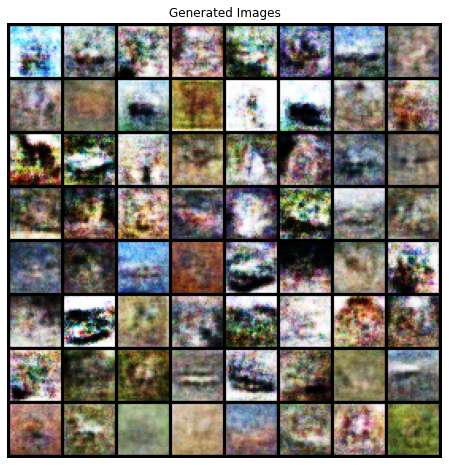

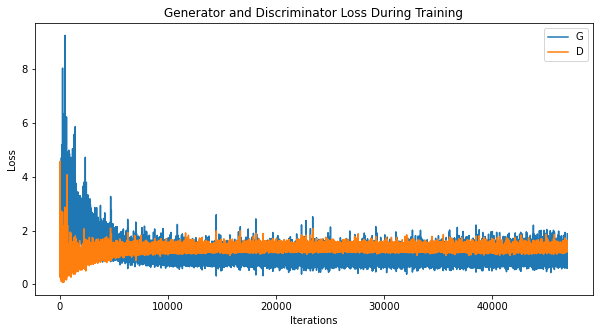

In [10]:
train('CIFAR10',5e-4,1e-3)

Files already downloaded and verified
Epoch [1/60], Step [1/782], d_loss: 1.3871632814407349, g_loss: 0.6916897296905518
Epoch [1/60], Step [101/782], d_loss: 0.43116578459739685, g_loss: 2.2085089683532715
Epoch [1/60], Step [201/782], d_loss: 0.8633524179458618, g_loss: 1.8763322830200195
Epoch [1/60], Step [301/782], d_loss: 0.6748513579368591, g_loss: 2.930936336517334
Epoch [1/60], Step [401/782], d_loss: 0.6489430665969849, g_loss: 1.7042347192764282
Epoch [1/60], Step [501/782], d_loss: 0.8007860779762268, g_loss: 1.1618173122406006
Epoch [1/60], Step [601/782], d_loss: 0.42577454447746277, g_loss: 3.9388980865478516
Epoch [1/60], Step [701/782], d_loss: 1.4240214824676514, g_loss: 1.335709810256958
Epoch [2/60], Step [1/782], d_loss: 0.9648377895355225, g_loss: 1.2476850748062134
Epoch [2/60], Step [101/782], d_loss: 0.8425834774971008, g_loss: 1.7444992065429688
Epoch [2/60], Step [201/782], d_loss: 0.6058609485626221, g_loss: 1.4881572723388672
Epoch [2/60], Step [301/782], d

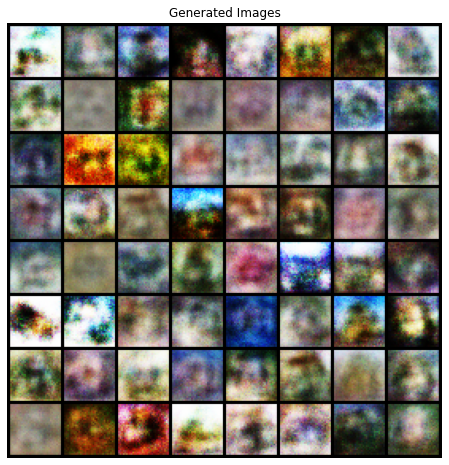

Epoch [11/60], Step [1/782], d_loss: 1.2045048475265503, g_loss: 1.5237478017807007
Epoch [11/60], Step [101/782], d_loss: 1.2099945545196533, g_loss: 1.0810601711273193
Epoch [11/60], Step [201/782], d_loss: 1.3816134929656982, g_loss: 1.0769450664520264
Epoch [11/60], Step [301/782], d_loss: 1.2903974056243896, g_loss: 0.9473254084587097
Epoch [11/60], Step [401/782], d_loss: 1.3169341087341309, g_loss: 1.1734428405761719
Epoch [11/60], Step [501/782], d_loss: 1.1903737783432007, g_loss: 1.3155810832977295
Epoch [11/60], Step [601/782], d_loss: 1.308749794960022, g_loss: 0.7743067741394043
Epoch [11/60], Step [701/782], d_loss: 1.2592923641204834, g_loss: 1.105588674545288
Epoch [12/60], Step [1/782], d_loss: 1.4519693851470947, g_loss: 1.2698602676391602
Epoch [12/60], Step [101/782], d_loss: 1.3409429788589478, g_loss: 1.256195068359375
Epoch [12/60], Step [201/782], d_loss: 1.315537452697754, g_loss: 1.8163120746612549
Epoch [12/60], Step [301/782], d_loss: 1.5533339977264404, g_l

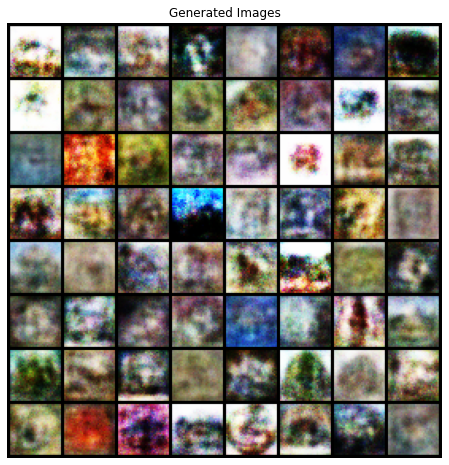

Epoch [21/60], Step [1/782], d_loss: 1.296626329421997, g_loss: 0.8943274021148682
Epoch [21/60], Step [101/782], d_loss: 1.2382655143737793, g_loss: 0.9737292528152466
Epoch [21/60], Step [201/782], d_loss: 1.6141167879104614, g_loss: 0.7397114634513855
Epoch [21/60], Step [301/782], d_loss: 1.3071236610412598, g_loss: 1.488518476486206
Epoch [21/60], Step [401/782], d_loss: 1.383791208267212, g_loss: 0.7500121593475342
Epoch [21/60], Step [501/782], d_loss: 1.4233782291412354, g_loss: 0.9844558238983154
Epoch [21/60], Step [601/782], d_loss: 1.4179432392120361, g_loss: 0.8082070350646973
Epoch [21/60], Step [701/782], d_loss: 1.3321914672851562, g_loss: 0.5861179828643799
Epoch [22/60], Step [1/782], d_loss: 1.4597206115722656, g_loss: 1.1423815488815308
Epoch [22/60], Step [101/782], d_loss: 1.4556138515472412, g_loss: 1.2430827617645264
Epoch [22/60], Step [201/782], d_loss: 1.5558122396469116, g_loss: 1.354897141456604
Epoch [22/60], Step [301/782], d_loss: 1.5341719388961792, g_l

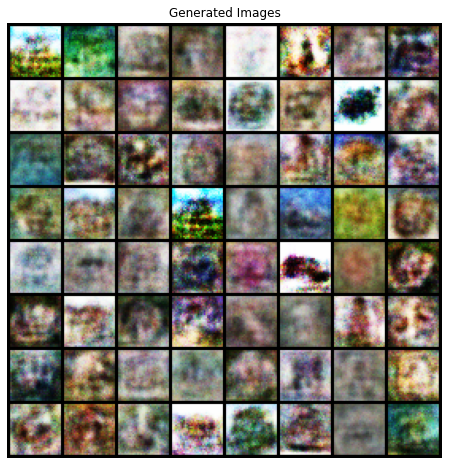

Epoch [31/60], Step [1/782], d_loss: 1.4868508577346802, g_loss: 1.055112600326538
Epoch [31/60], Step [101/782], d_loss: 1.3444777727127075, g_loss: 0.8831136226654053
Epoch [31/60], Step [201/782], d_loss: 1.3516592979431152, g_loss: 0.8652694225311279
Epoch [31/60], Step [301/782], d_loss: 1.2950180768966675, g_loss: 0.7782350182533264
Epoch [31/60], Step [401/782], d_loss: 1.3502808809280396, g_loss: 1.053635835647583
Epoch [31/60], Step [501/782], d_loss: 1.3884730339050293, g_loss: 1.1351760625839233
Epoch [31/60], Step [601/782], d_loss: 1.3143911361694336, g_loss: 0.8677817583084106
Epoch [31/60], Step [701/782], d_loss: 1.3307244777679443, g_loss: 0.6864696741104126
Epoch [32/60], Step [1/782], d_loss: 1.508809208869934, g_loss: 0.7034353017807007
Epoch [32/60], Step [101/782], d_loss: 1.3879588842391968, g_loss: 1.080463171005249
Epoch [32/60], Step [201/782], d_loss: 1.350844144821167, g_loss: 0.9016786813735962
Epoch [32/60], Step [301/782], d_loss: 1.4613885879516602, g_lo

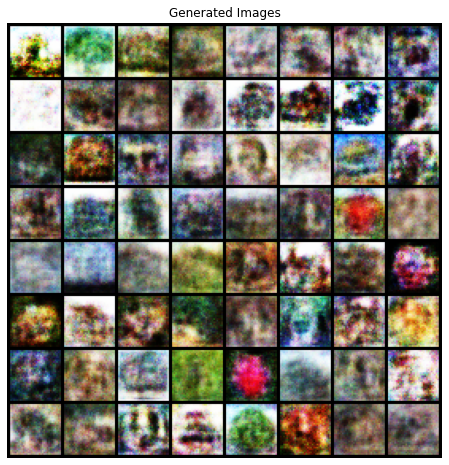

Epoch [41/60], Step [1/782], d_loss: 1.4366161823272705, g_loss: 1.0443565845489502
Epoch [41/60], Step [101/782], d_loss: 1.4464828968048096, g_loss: 0.8961814641952515
Epoch [41/60], Step [201/782], d_loss: 1.464336633682251, g_loss: 0.9782527089118958
Epoch [41/60], Step [301/782], d_loss: 1.4355520009994507, g_loss: 1.0204977989196777
Epoch [41/60], Step [401/782], d_loss: 1.4684021472930908, g_loss: 1.6737163066864014
Epoch [41/60], Step [501/782], d_loss: 1.4315998554229736, g_loss: 0.7831174731254578
Epoch [41/60], Step [601/782], d_loss: 1.304203987121582, g_loss: 1.0827466249465942
Epoch [41/60], Step [701/782], d_loss: 1.2021384239196777, g_loss: 1.0342316627502441
Epoch [42/60], Step [1/782], d_loss: 1.5816497802734375, g_loss: 0.7595648765563965
Epoch [42/60], Step [101/782], d_loss: 1.3352676630020142, g_loss: 1.9835731983184814
Epoch [42/60], Step [201/782], d_loss: 1.296156644821167, g_loss: 0.7653495073318481
Epoch [42/60], Step [301/782], d_loss: 1.3675906658172607, g_

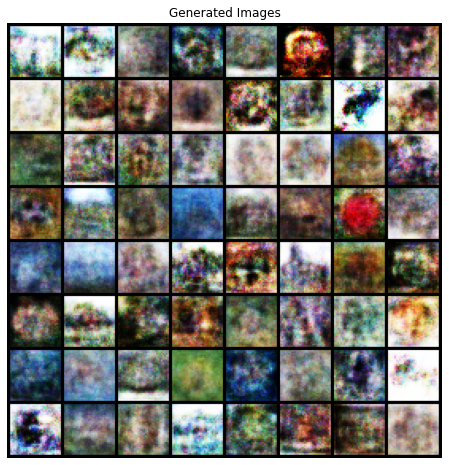

Epoch [51/60], Step [1/782], d_loss: 1.3220829963684082, g_loss: 1.1988996267318726
Epoch [51/60], Step [101/782], d_loss: 1.2863080501556396, g_loss: 0.7920395135879517
Epoch [51/60], Step [201/782], d_loss: 1.3193731307983398, g_loss: 0.9788519740104675
Epoch [51/60], Step [301/782], d_loss: 1.4125494956970215, g_loss: 0.7441180944442749
Epoch [51/60], Step [401/782], d_loss: 1.4810452461242676, g_loss: 0.684217095375061
Epoch [51/60], Step [501/782], d_loss: 1.371736764907837, g_loss: 1.037057876586914
Epoch [51/60], Step [601/782], d_loss: 1.5875012874603271, g_loss: 0.6949706673622131
Epoch [51/60], Step [701/782], d_loss: 1.354400396347046, g_loss: 0.9639110565185547
Epoch [52/60], Step [1/782], d_loss: 1.553634762763977, g_loss: 1.1066346168518066
Epoch [52/60], Step [101/782], d_loss: 1.3729684352874756, g_loss: 0.8445437550544739
Epoch [52/60], Step [201/782], d_loss: 1.2949192523956299, g_loss: 0.656794548034668
Epoch [52/60], Step [301/782], d_loss: 1.3806514739990234, g_los

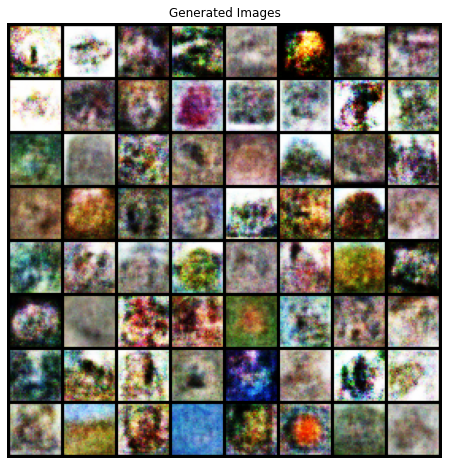

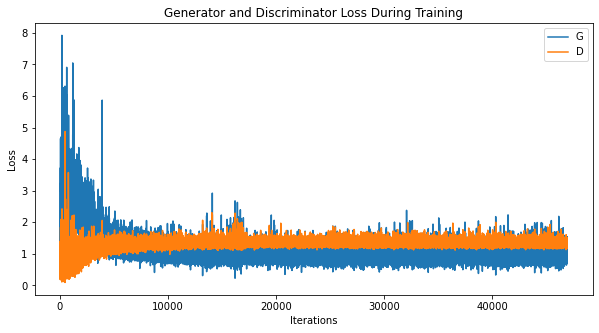

In [5]:
train('CIFAR100',5e-4,1e-3)